In [1]:
!pip install librosa seaborn --quiet
# !pip install librosa==0.9.2

## 1. Load Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

100%|██████████| 429M/429M [00:43<00:00, 10.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


In [3]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.utils import to_categorical

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
Ravdess = "/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/"

In [ ]:
# The RAVDESS filenames are structured as:
#  Modality (01 = speech)
#  Vocal channel (01 = speech)
#  Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad,
#           05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
#  Emotional intensity (01 = normal, 02 = strong)
#  Statement (01, 02)
#  Repetition (01, 02)
#  Actor (01 to 24)

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

for dir_ in ravdess_directory_list:
    # If there are hidden files or non-directory elements, skip
    if dir_.startswith('.'):
        continue
    actor_path = os.path.join(Ravdess, dir_)
    if os.path.isdir(actor_path):
        actor_files = os.listdir(actor_path)
        for file in actor_files:
            if file.endswith('.wav'):
                part = file.split('.')[0].split('-')
                emotion_code = int(part[2])
                file_emotion.append(emotion_code)
                file_path.append(os.path.join(actor_path, file))

Ravdess_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

# Instead of using inplace=True, directly assign the replaced values
Ravdess_df['Emotions'] = Ravdess_df['Emotions'].replace({
    1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry',
    6:'fear', 7:'disgust', 8:'surprise'
})

# Display the first few rows to confirm
print(Ravdess_df.head())

   Emotions                                               Path
0     angry  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1  surprise  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
2     happy  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
3      calm  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
4       sad  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...


## EDA

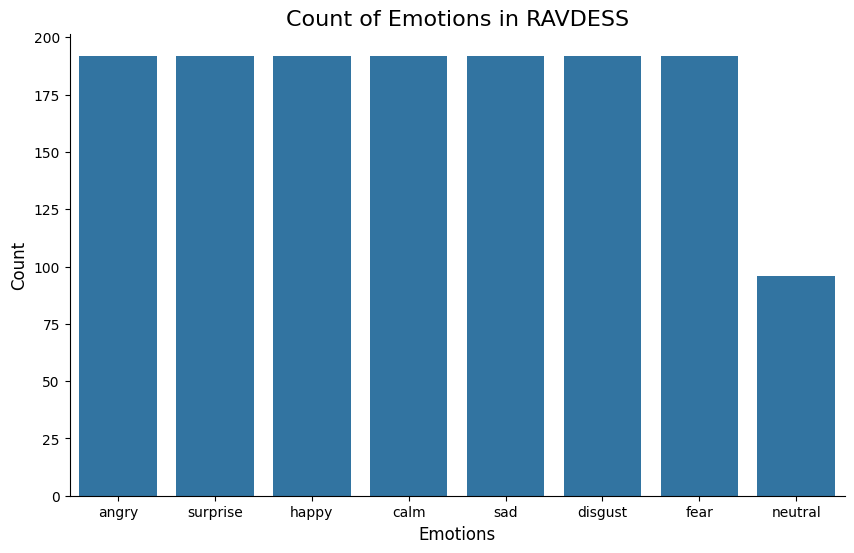

In [6]:
plt.figure(figsize=(10,6))
plt.title('Count of Emotions in RAVDESS', size=16)
sns.countplot(x='Emotions', data=Ravdess_df)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True)
plt.show()

In [7]:
neutral_df = Ravdess_df[Ravdess_df.Emotions == 'neutral']
num_to_add = 96
oversampled_neutral = neutral_df.sample(n=num_to_add, replace=True)
balanced_df = pd.concat([Ravdess_df, oversampled_neutral], ignore_index=True)

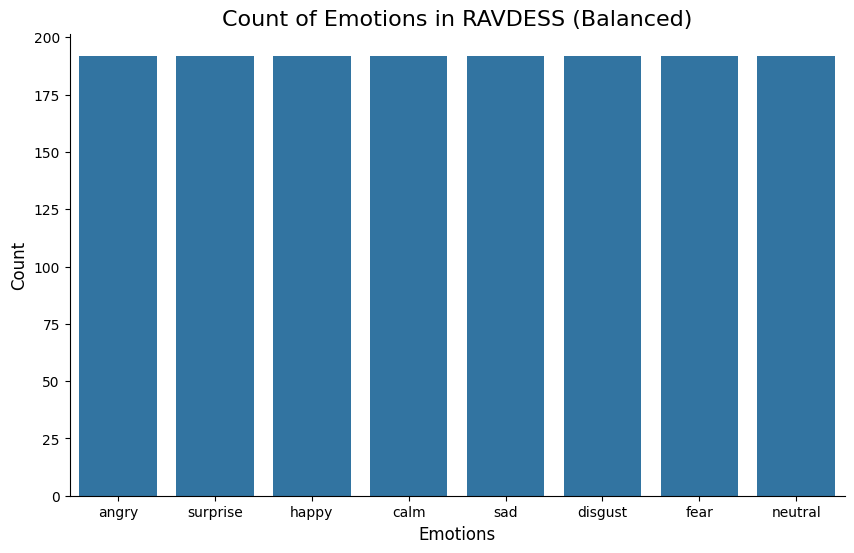

In [8]:
plt.figure(figsize=(10,6))
plt.title('Count of Emotions in RAVDESS (Balanced)', size=16)
sns.countplot(x='Emotions', data=balanced_df)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True)
plt.show()

In [9]:
# visualizing a few waveforms and spectrograms
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

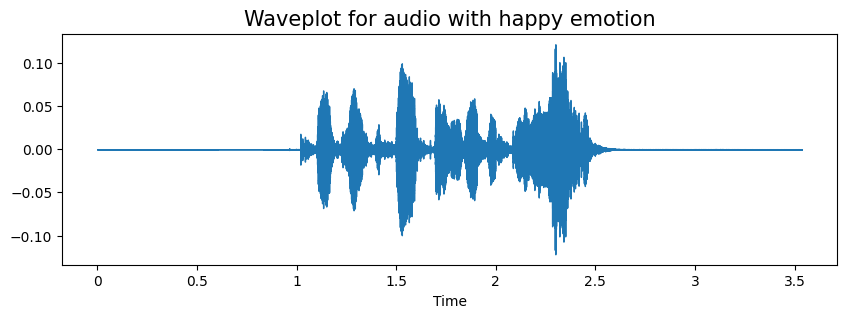

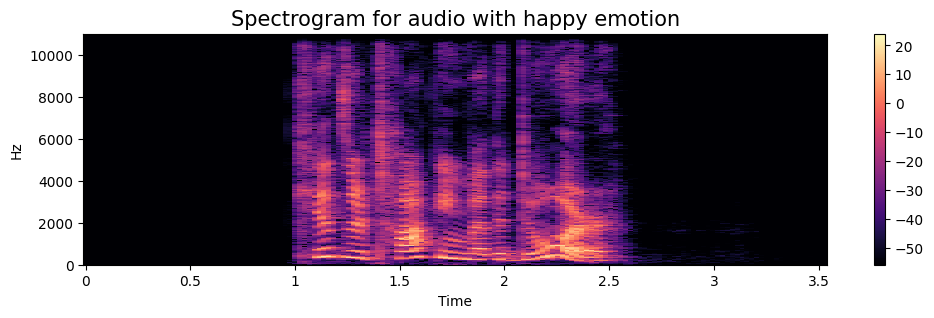

In [10]:
# Example visualization
example_emotion = 'happy'
example_path = Ravdess_df[Ravdess_df.Emotions == example_emotion].iloc[0].Path
data, sampling_rate = librosa.load(example_path)
create_waveplot(data, sampling_rate, example_emotion)
create_spectrogram(data, sampling_rate, example_emotion)
Audio(example_path)

## 3. Data Augmentation Functions

In [11]:
# Data Augmentation Functions
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    # Directly apply time stretching on the waveform with keyword arguments
    # This ensures that the correct arguments are passed even if there's a namespace conflict
    y_stretched = librosa.effects.time_stretch(y=data, rate=rate)
    return y_stretched

def pitch(data, sr, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=pitch_factor)

## 4. Feature Extraction

In [12]:
def extract_features(data, sr):
    result = np.array([])

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mfcc))

    # RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mel))

    return result

In [13]:
def get_features(path):
    data, sr = librosa.load(path, duration=2.5, offset=0.6)
    # original
    res1 = extract_features(data, sr)
    result = np.array(res1)

    # with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sr)
    result = np.vstack((result, res2))

    # with stretching + pitching
    stretched_data = stretch(data)
    pitched_data = pitch(stretched_data, sr)
    res3 = extract_features(pitched_data, sr)
    result = np.vstack((result, res3))

    return result

In [14]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

X = np.array(X)
Y = np.array(Y)

In [15]:
# One-hot encode targets
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1,1)).toarray()

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

# Normalize data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Add channel dimension
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [16]:
# 5. Model Building
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='softmax'))  # 8 emotions in RAVDESS

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 81, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          22,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Reduce learning rate on plateau
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=1e-7)

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.1867 - loss: 2.0301 - val_accuracy: 0.2139 - val_loss: 1.9193 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2274 - loss: 1.9485 - val_accuracy: 0.2481 - val_loss: 1.8751 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2470 - loss: 1.8844 - val_accuracy: 0.3056 - val_loss: 1.7819 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2934 - loss: 1.8028 - val_accuracy: 0.3250 - val_loss: 1.7752 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2748 - loss: 1.8130 - val_accuracy: 0.3231 - val_loss: 1.7074 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3148 - loss: 1.7511 - val_accuracy: 0.3583 - val_loss: 1.6632 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3357 - loss: 1.6877 - val_accura

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6154 - loss: 1.2844
Test Accuracy: 60.37%


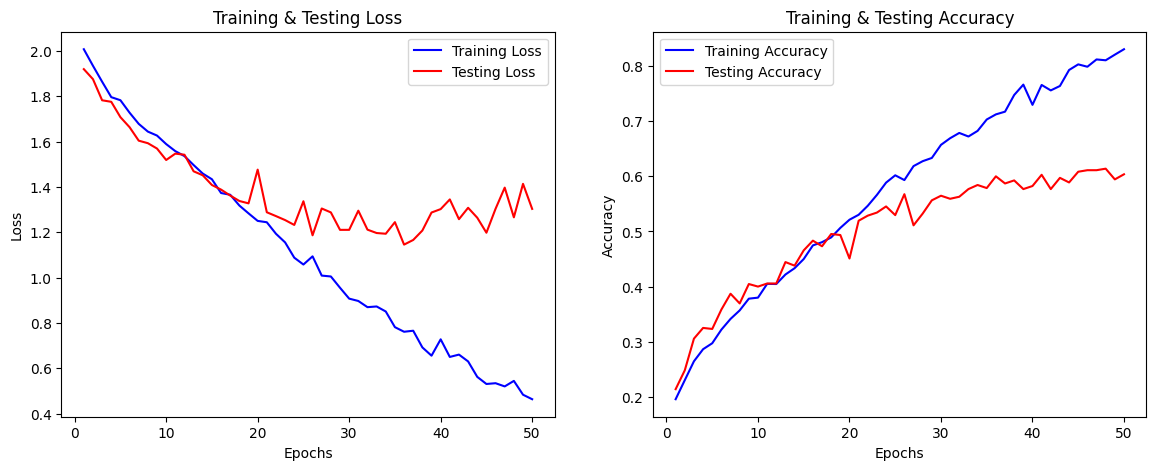

In [18]:
# 6. Evaluation
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Plotting Accuracy and Loss
epochs = range(1,51)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Testing Loss')
plt.title('Training & Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Predictions and Confusion Matrix
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


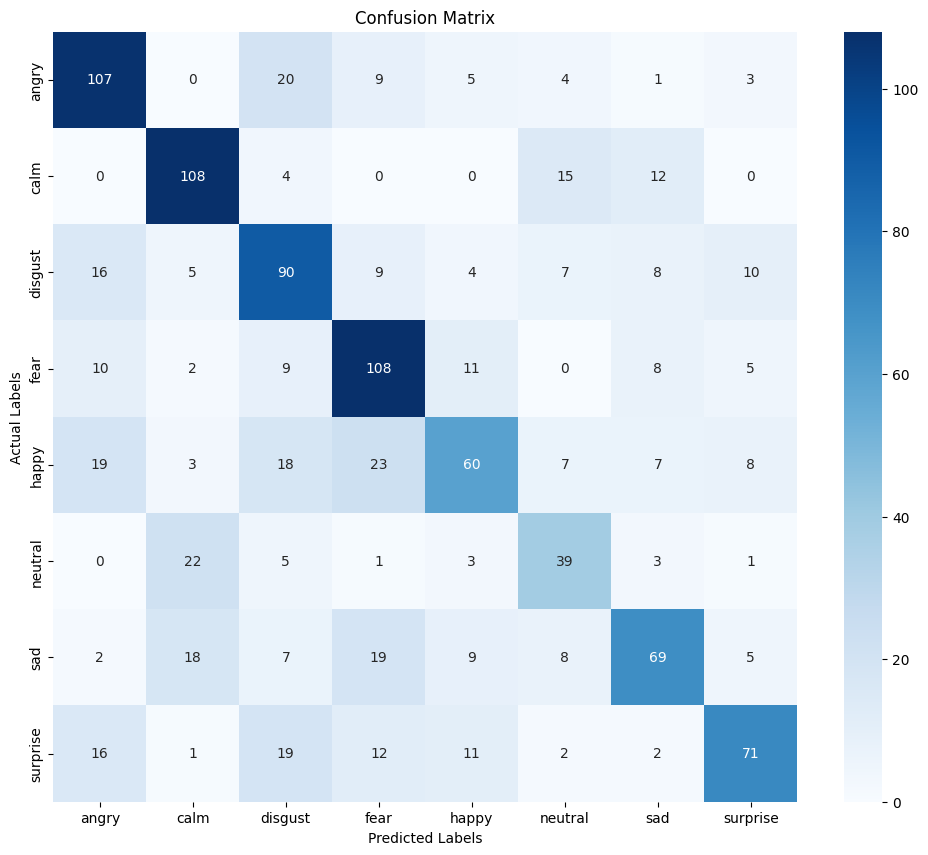

In [20]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
cm_df = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [21]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       angry       0.63      0.72      0.67       149
        calm       0.68      0.78      0.72       139
     disgust       0.52      0.60      0.56       149
        fear       0.60      0.71      0.65       153
       happy       0.58      0.41      0.48       145
     neutral       0.48      0.53      0.50        74
         sad       0.63      0.50      0.56       137
    surprise       0.69      0.53      0.60       134

    accuracy                           0.60      1080
   macro avg       0.60      0.60      0.59      1080
weighted avg       0.61      0.60      0.60      1080



In [22]:
import joblib
from keras.models import load_model
from google.colab import files

In [23]:
model.save('emotion_model.keras')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [24]:
files.download('emotion_model.keras')
files.download('scaler.pkl')
files.download('encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Trying to improve

In [25]:
Tess = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
TESS_directory_list = os.listdir(Tess)
Crema = kagglehub.dataset_download("ejlok1/cremad")
CremaD_directory_list = os.listdir(Crema)
Savee = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
Savee_directory_list = os.listdir(Savee)

100%|██████████| 428M/428M [00:08<00:00, 51.4MB/s]

Extracting files...


100%|██████████| 451M/451M [00:03<00:00, 149MB/s]

Extracting files...


100%|██████████| 107M/107M [00:01<00:00, 107MB/s] 

Extracting files...


In [ ]:
# Crema = "/path_to_crema/"
# Tess = "/path_to_tess/"
# Savee = "/path_to_savee/"

In [26]:
# Load CREMA DataFrame (Adjust paths accordingly)
crema_emotion = []
crema_path = []
for file in os.listdir(Crema):
    if file.endswith('.wav'):
        file_path = os.path.join(Crema, file)
        part = file.split('_')
        # Map according to the CREMA naming scheme
        if part[2] == 'SAD':
            crema_emotion.append('sad')
        elif part[2] == 'ANG':
            crema_emotion.append('angry')
        elif part[2] == 'DIS':
            crema_emotion.append('disgust')
        elif part[2] == 'FEA':
            crema_emotion.append('fear')
        elif part[2] == 'HAP':
            crema_emotion.append('happy')
        elif part[2] == 'NEU':
            crema_emotion.append('neutral')
        else:
            crema_emotion.append('Unknown')
        crema_path.append(file_path)
Crema_df = pd.DataFrame({'Emotions': crema_emotion, 'Path': crema_path})

In [27]:
# Load TESS DataFrame
tess_emotion = []
tess_path = []
for folder in os.listdir(Tess):
    folder_path = os.path.join(Tess, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                part = file.split('.')[0].split('_')[-1]
                if part == 'ps':
                    tess_emotion.append('surprise')
                else:
                    tess_emotion.append(part)
                tess_path.append(os.path.join(folder_path, file))
Tess_df = pd.DataFrame({'Emotions': tess_emotion, 'Path': tess_path})


In [28]:
# Load SAVEE DataFrame
savee_emotion = []
savee_path = []
for file in os.listdir(Savee):
    if file.endswith('.wav'):
        file_path = os.path.join(Savee, file)
        part = file.split('_')[1][:-6]
        if part == 'a':
            savee_emotion.append('angry')
        elif part == 'd':
            savee_emotion.append('disgust')
        elif part == 'f':
            savee_emotion.append('fear')
        elif part == 'h':
            savee_emotion.append('happy')
        elif part == 'n':
            savee_emotion.append('neutral')
        elif part == 'sa':
            savee_emotion.append('sad')
        else:
            savee_emotion.append('surprise')
        savee_path.append(file_path)
Savee_df = pd.DataFrame({'Emotions': savee_emotion, 'Path': savee_path})


In [29]:
# Combine all DataFrames
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], ignore_index=True)


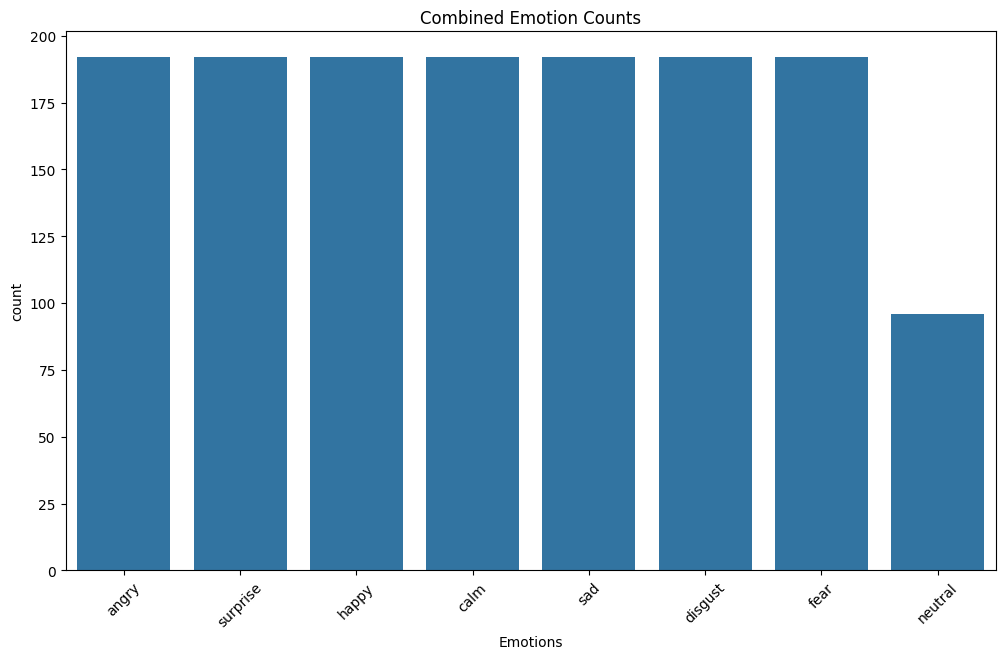

In [30]:
# Perform EDA
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
sns.countplot(x='Emotions', data=data_path)
plt.title("Combined Emotion Counts")
plt.xticks(rotation=45)
plt.show()

In [38]:
neutral_df = Ravdess_df[Ravdess_df.Emotions == 'neutral']
num_to_add = 96
oversampled_neutral = neutral_df.sample(n=num_to_add, replace=True)
balanced_df = pd.concat([Ravdess_df, oversampled_neutral], ignore_index=True)

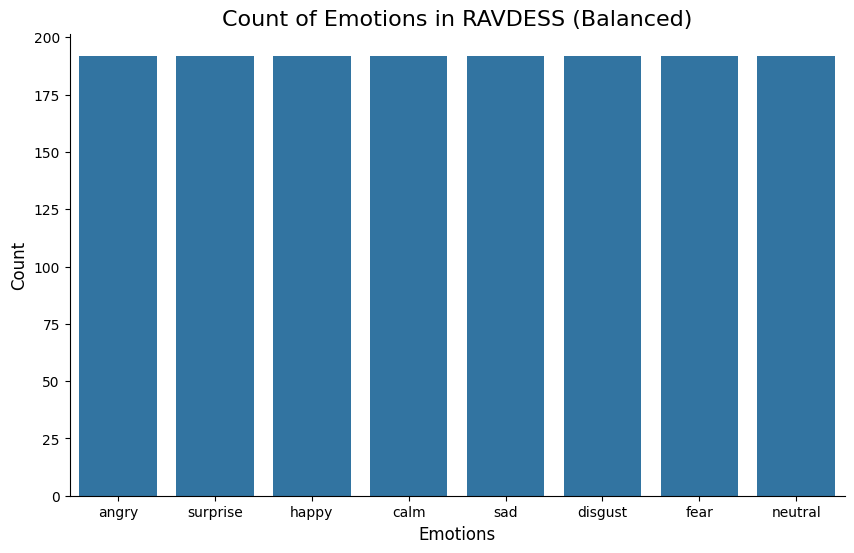

In [39]:
plt.figure(figsize=(10,6))
plt.title('Count of Emotions in Dataset (Balanced)', size=16)
sns.countplot(x='Emotions', data=balanced_df)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True)
plt.show()

In [40]:
# Feature extraction (assuming get_features is defined as before)
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feats = get_features(path)  # uses the same augmentations as before
    for ele in feats:
        X.append(ele)
        Y.append(emotion)

X = np.array(X)
Y = np.array(Y)

In [41]:
# One-hot encode targets
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1,1)).toarray()

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

# Normalize data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Add channel dimension
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [42]:
# 5. Model Building
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='softmax'))  # 8 emotions in RAVDESS

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 81, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │          22,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Reduce learning rate on plateau
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=1e-7)

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.1515 - loss: 2.0383 - val_accuracy: 0.2167 - val_loss: 1.9540 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2083 - loss: 1.9537 - val_accuracy: 0.2778 - val_loss: 1.8671 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2585 - loss: 1.8683 - val_accuracy: 0.3028 - val_loss: 1.7899 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2989 - loss: 1.7912 - val_accuracy: 0.3306 - val_loss: 1.7227 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3225 - loss: 1.7230 - val_accuracy: 0.3537 - val_loss: 1.6634 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3411 - loss: 1.6947 - val_accuracy: 0.3611 - val_loss: 1.6247 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3568 - loss: 1.6368 - val_accura

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6458 - loss: 1.4286
Test Accuracy: 64.72%


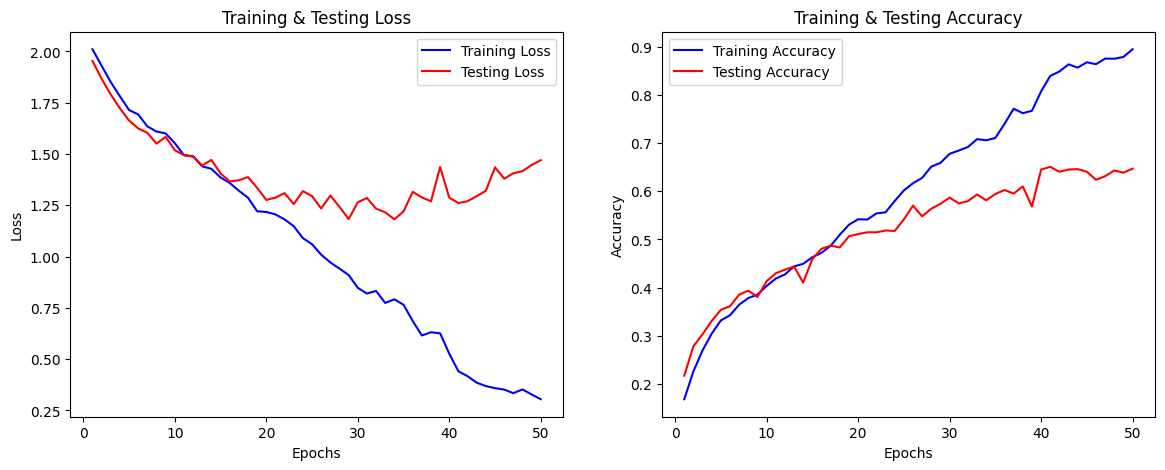

In [44]:
# 6. Evaluation
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Plotting Accuracy and Loss
epochs = range(1,51)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Testing Loss')
plt.title('Training & Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
# Predictions and Confusion Matrix
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


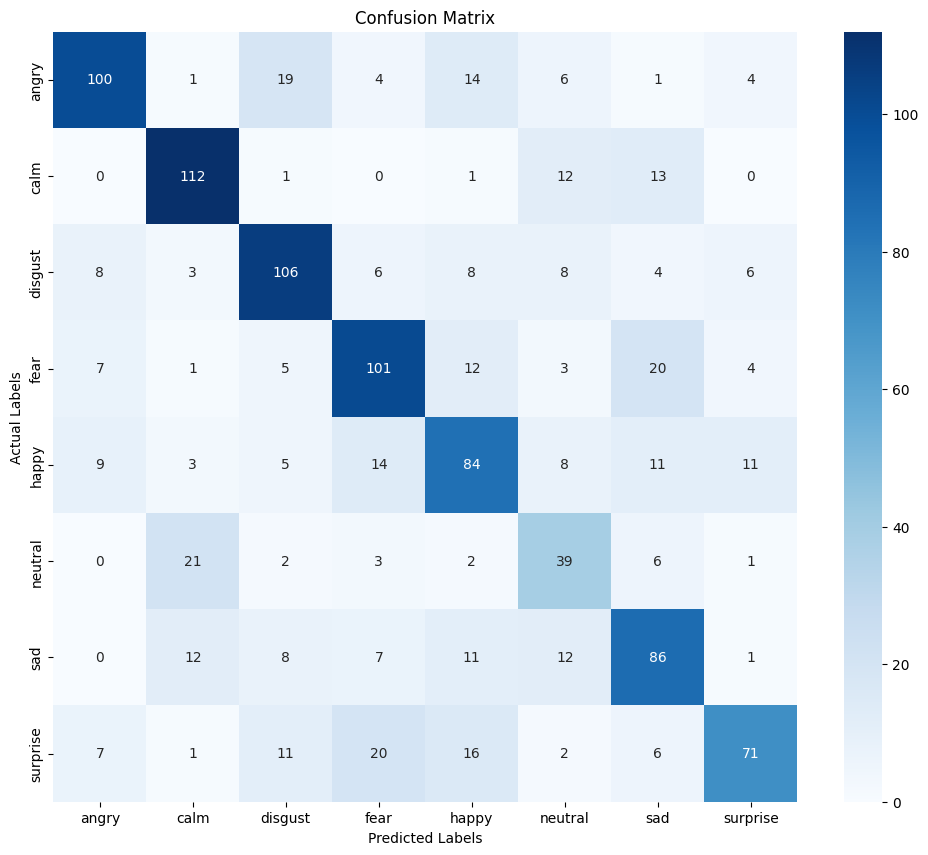

              precision    recall  f1-score   support

       angry       0.76      0.67      0.71       149
        calm       0.73      0.81      0.76       139
     disgust       0.68      0.71      0.69       149
        fear       0.65      0.66      0.66       153
       happy       0.57      0.58      0.57       145
     neutral       0.43      0.53      0.48        74
         sad       0.59      0.63      0.61       137
    surprise       0.72      0.53      0.61       134

    accuracy                           0.65      1080
   macro avg       0.64      0.64      0.64      1080
weighted avg       0.65      0.65      0.65      1080



In [46]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
cm_df = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()
print(classification_report(y_true, y_pred))

In [47]:
model.save('emotion_model_Final.keras')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [48]:
files.download('emotion_model.keras')
files.download('scaler.pkl')
files.download('encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>